### Re-run some analyses for just Hippocampus/MTL units
All the previous decoding analyses, just using subset of HC units, also compare with PFC units

In [3]:
%load_ext autoreload
%autoreload 2

import os
import numpy as np
import pandas as pd
import utils.behavioral_utils as behavioral_utils
import utils.information_utils as information_utils
import utils.visualization_utils as visualization_utils
import utils.pseudo_classifier_utils as pseudo_classifier_utils
import utils.io_utils as io_utils

import utils.glm_utils as glm_utils
from matplotlib import pyplot as plt
import utils.spike_utils as spike_utils
import utils.subspace_utils as subspace_utils
from trial_splitters.condition_trial_splitter import ConditionTrialSplitter 
from utils.session_data import SessionData

import scipy
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression


In [4]:
FEATURE_DIMS = ["Color", "Shape", "Pattern"]
REGIONS = ["all", "hip", "pfc"]
PRE_INTERVAL = 1300
POST_INTERVAL = 1500
INTERVAL_SIZE = 100
SMOOTH = 1
EVENT = "FeedbackOnset"
OUTPUT_DIR = "/data/patrick_res/hyak/pseudo"
# path to a dataframe of sessions to analyze
SESSIONS_PATH = "/data/patrick_res/sessions/valid_sessions_rpe.pickle"

### Decoding of selected features, fixations, split by regions

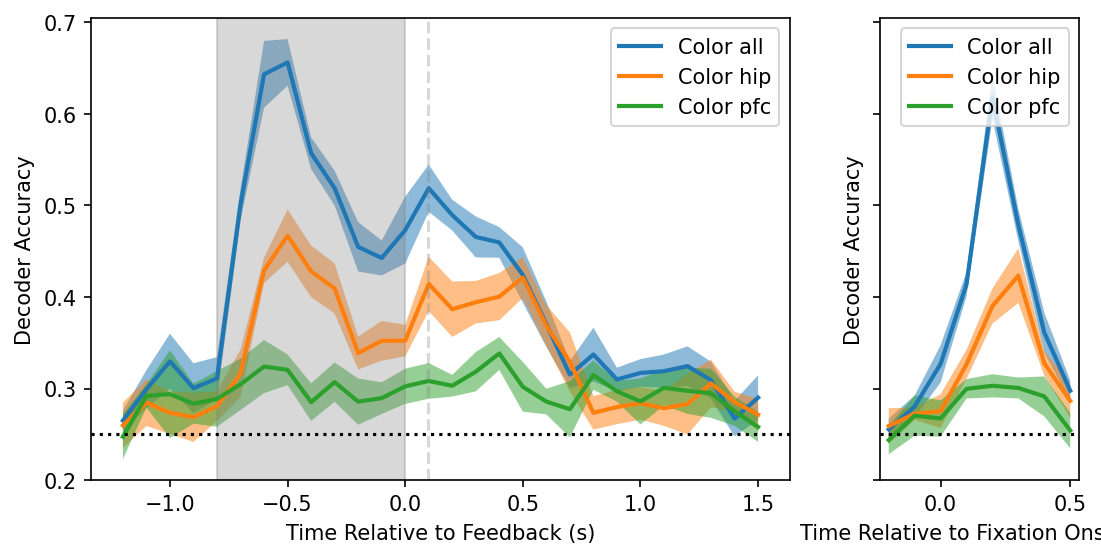

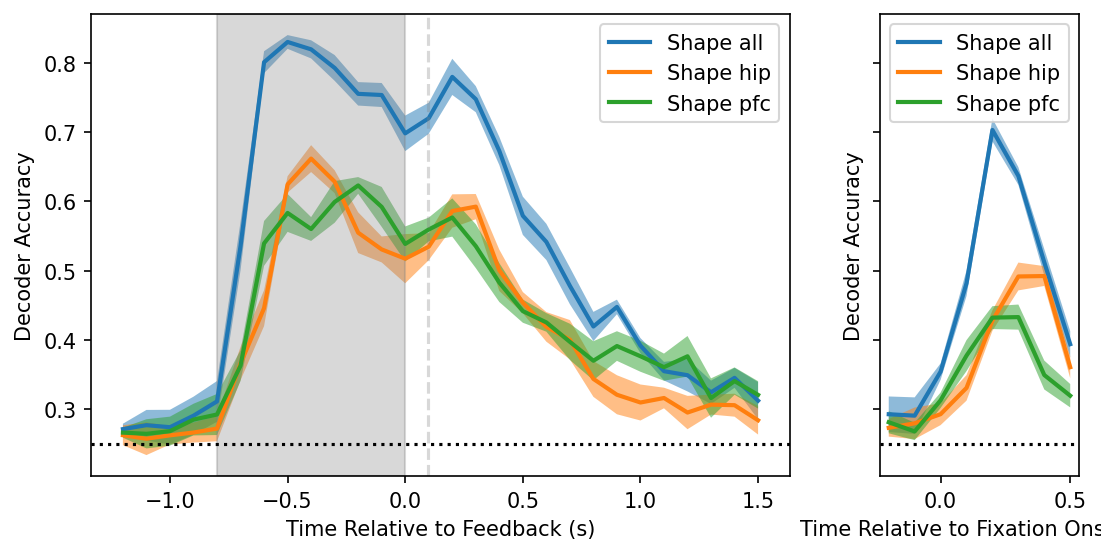

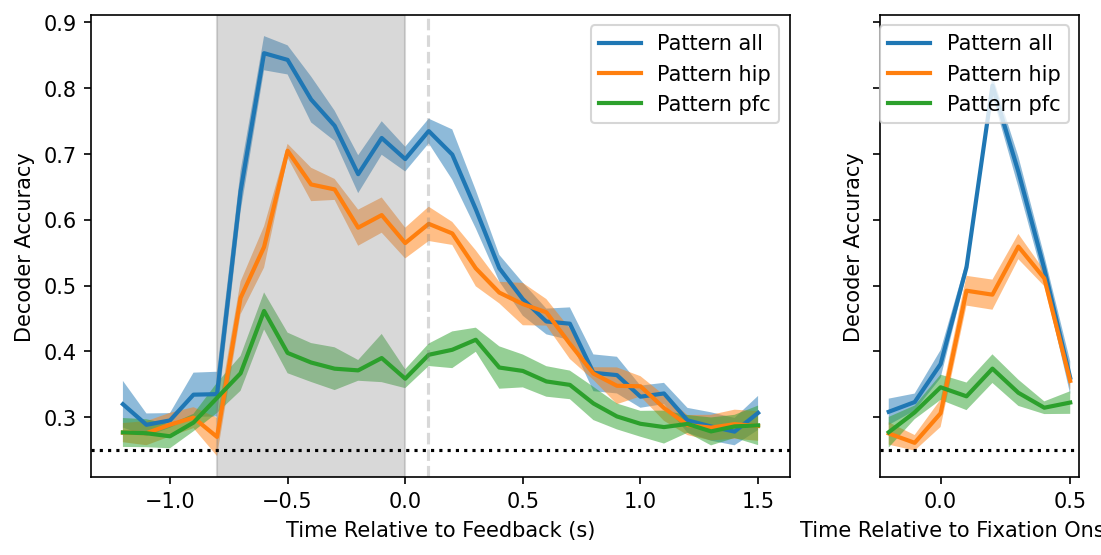

In [5]:
for feature_dim in FEATURE_DIMS:
    fig, axs = plt.subplots(1, 2, figsize=(8.5, 4), sharey=True, gridspec_kw={'width_ratios': [7, 2]}, dpi=150)
    for region in REGIONS:
        feature_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_baseline_{region}_all_no_proj_0.0_test_accs.npy"))
        fix_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_fixations_{region}_test_accs.npy"))

        # plots the mean and standard deviation of decoding accuracy across splits, by time. 
        visualization_utils.visualize_accuracy_across_time_bins(
            feature_accs,
            PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
            axs[0],
            label=f"{feature_dim} {region}",
            right_align=True, 
        )
        # plots the mean and standard deviation of decoding accuracy across splits, by time. 
        visualization_utils.visualize_accuracy_across_time_bins(
            fix_accs,
            0.3, 0.5, 0.1,
            axs[1],
            label=f"{feature_dim} {region}",
            right_align=True, 
        )
    ax = axs[0]
    ax.legend()
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    # add estimated chance
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")

    ax = axs[1]
    ax.legend()
    ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Fixation Onset (s)")
    ax.set_ylabel("Decoder Accuracy")

### Cross decoding for selected features

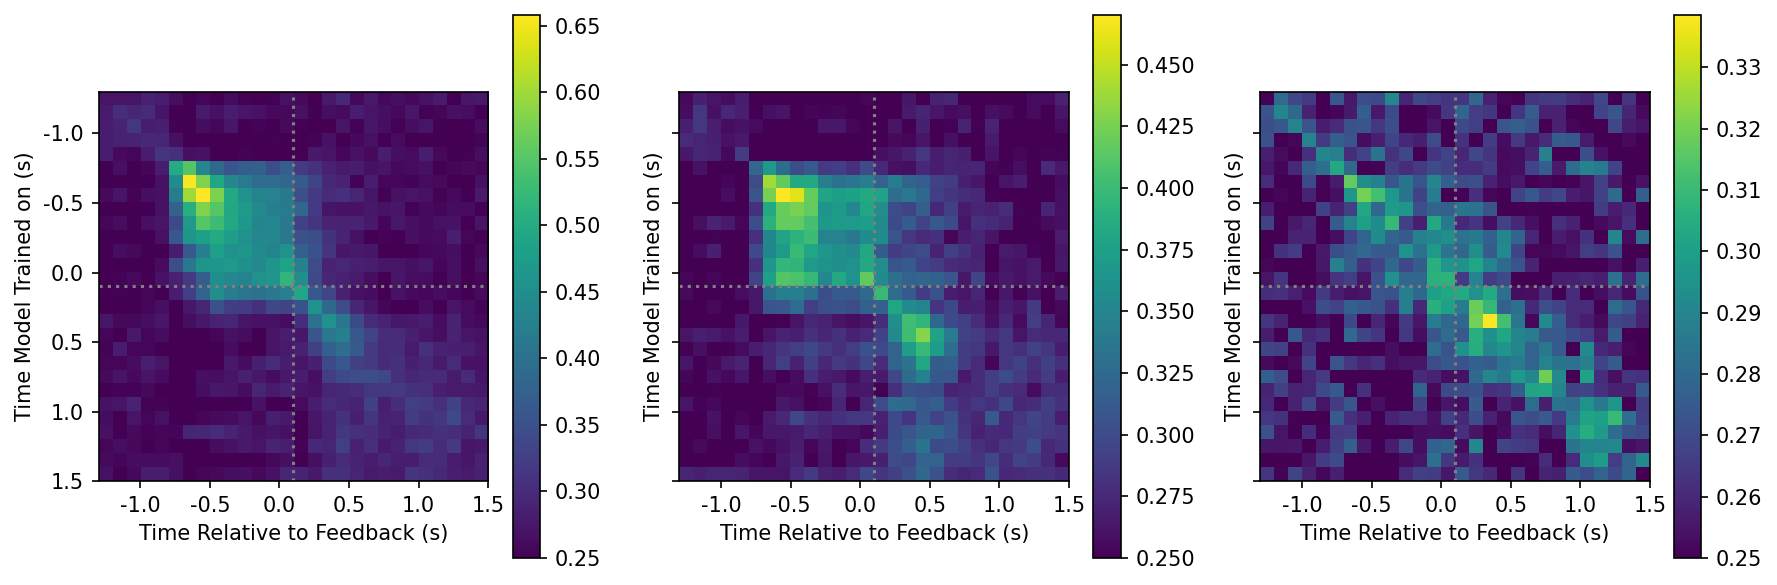

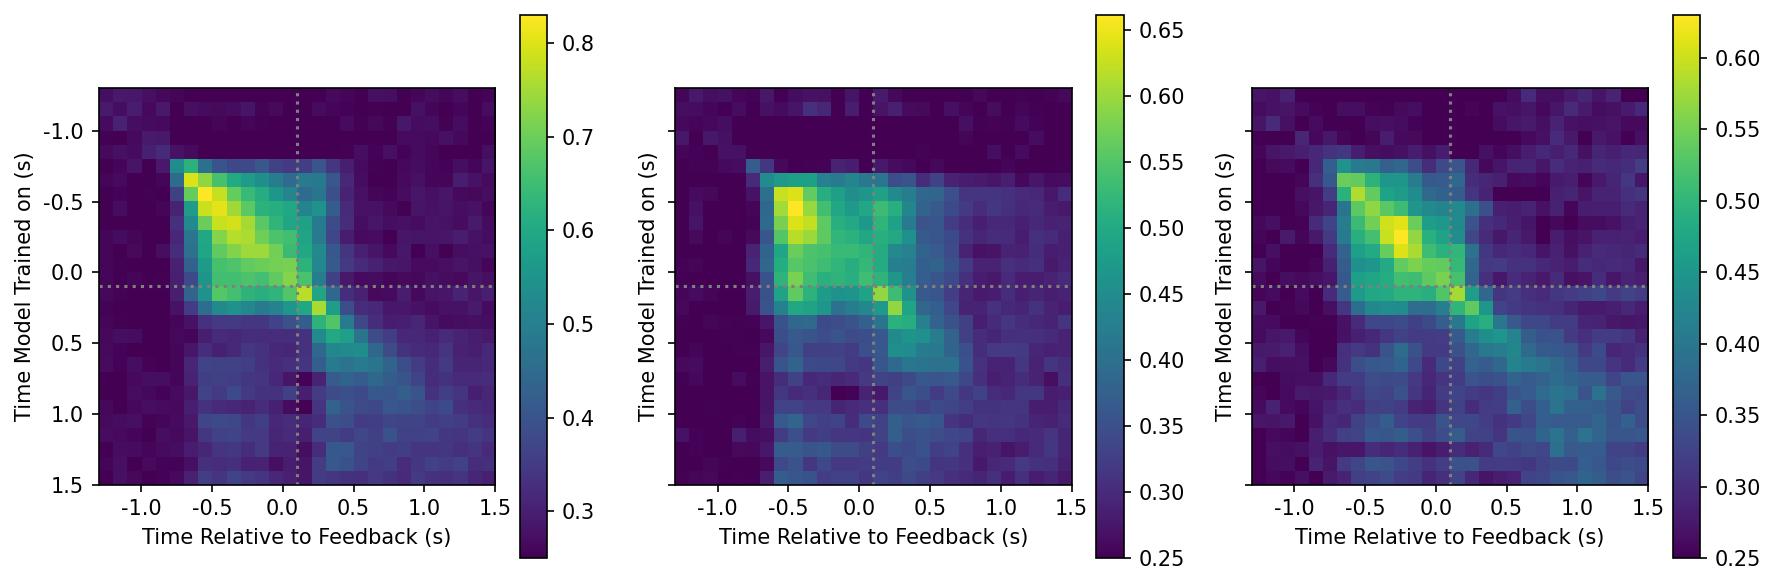

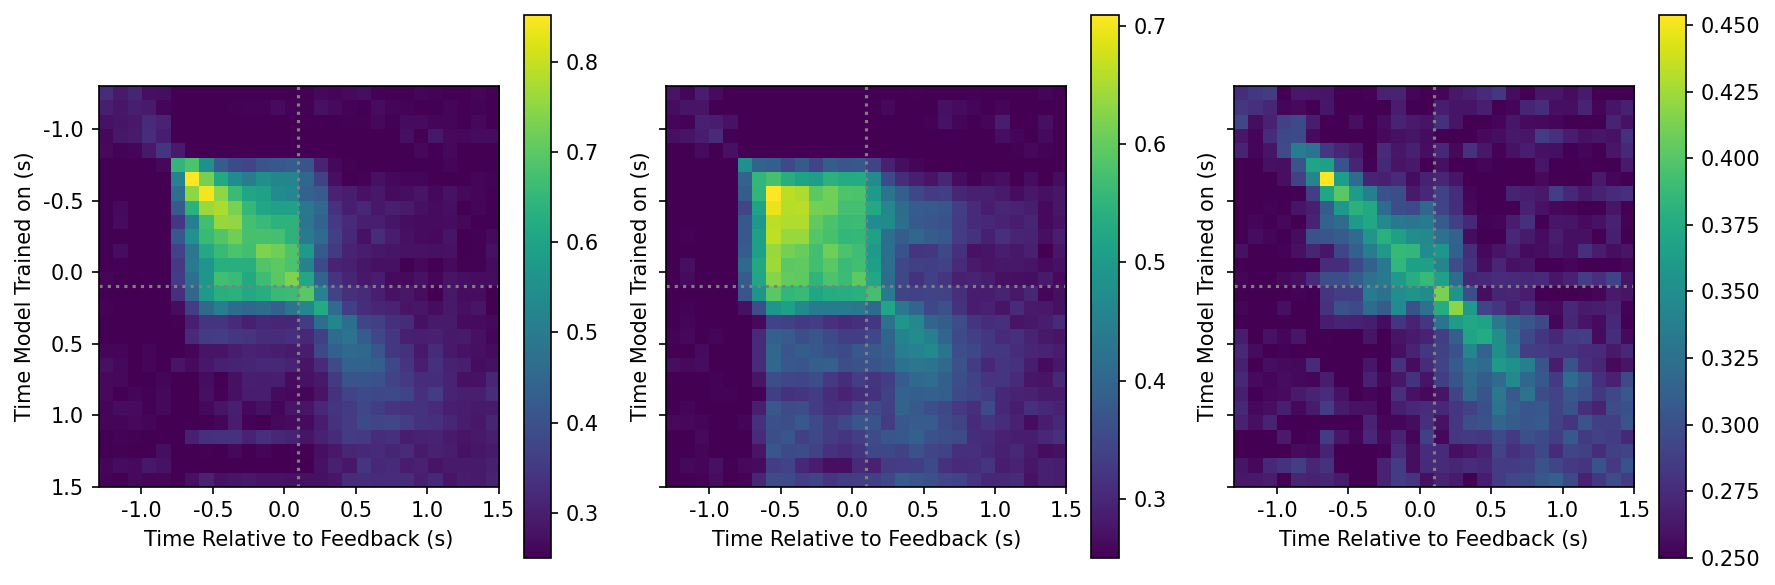

In [20]:
interval_size = 100
# plt.rcParams.update({'font.size': 12.5})
LOCAL_OUTPUT_DIR = "/data/patrick_res/pseudo"
for feature_dim in FEATURE_DIMS:
    fig, axs = plt.subplots(1, 3, figsize=(12, 4), sharey=True, dpi=150)
    for i, region in enumerate(REGIONS):
    # for i, region in enumerate(["pfc", "hip"]):
        if region in ["pfc", "hip"]:
            cross_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_cross_acc_{region}.npy"))
            cross_accs = np.mean(cross_accs, axis=2)
        else: 
            cross_accs = np.load(os.path.join(LOCAL_OUTPUT_DIR, f"{feature_dim}_rpe_sess_cross_accs.npy"))

        # cross_fix_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_selection_fixations_cross_accs.npy"))
        ax = axs[i]
        colors = ax.matshow(cross_accs)
        colors.set_clim(vmin=0.25)
        ratio = 1000 / interval_size
        tick_labels = np.array([-1, -0.5, 0, 0.5, 1.0, 1.5])
        tick_pos = (tick_labels + 1.3) * ratio - 0.5
        ax.set_xticks(tick_pos)
        ax.set_xticklabels(tick_labels)
        ax.xaxis.tick_bottom()
        ax.set_yticks(tick_pos)
        ax.set_yticklabels(tick_labels)
        ax.axvline(13.48, color="gray", linestyle="dotted", linewidth=1.5)
        ax.axhline(13.48, color="gray", linestyle="dotted", linewidth=1.5)
        # ax.set_title(feature_dim)
        ax.set_xlabel("Time Relative to Feedback (s)")
        ax.set_ylabel("Time Model Trained on (s)")
        fig.colorbar(colors, ax=ax)
    fig.tight_layout()
    # ax = axs[1]
    # # colors = ax.matshow(cross_fix_accs)
    # colors.set_clim(vmin=0.25)
    # ratio = 1000 / interval_size
    # x_tick_labels = np.array([0, 0.5])
    # x_tick_pos = (x_tick_labels + 0.3) * ratio - 0.5
    # ax.set_xticks(x_tick_pos)
    # ax.set_xticklabels(x_tick_labels)
    # ax.xaxis.tick_bottom()
    # ax.set_yticks(tick_pos)
    # ax.set_yticklabels(tick_labels)
    # ax.set_xlabel("Time Relative to Fixation (s)")





### Correct/Incorrect differences

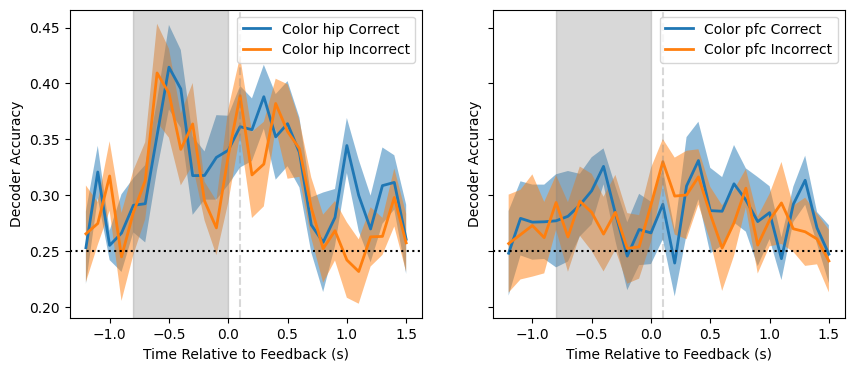

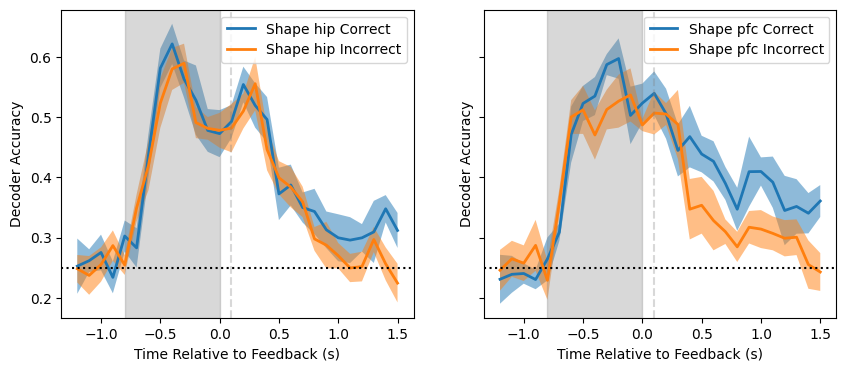

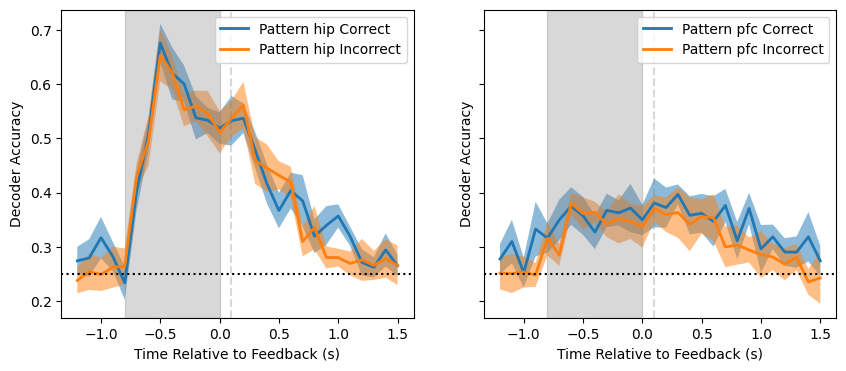

In [32]:
for feature_dim in FEATURE_DIMS:
    fig, axs = plt.subplots(1, 2, figsize=(10, 4), sharey=True)
    for i, region in enumerate(["hip", "pfc"]):
        ax = axs[i]
        cor_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_baseline_{region}_cor_bal_no_proj_0.0_test_accs.npy"))
        inc_accs = np.load(os.path.join(OUTPUT_DIR, f"{feature_dim}_baseline_{region}_inc_bal_no_proj_0.0_test_accs.npy"))

        # plots the mean and standard deviation of decoding accuracy across splits, by time. 
        visualization_utils.visualize_accuracy_across_time_bins(
            cor_accs,
            PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
            ax,
            label=f"{feature_dim} {region} Correct",
            right_align=True, 
        )
        # plots the mean and standard deviation of decoding accuracy across splits, by time. 
        visualization_utils.visualize_accuracy_across_time_bins(
            inc_accs,
            PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
            ax,
            label=f"{feature_dim} {region} Incorrect",
            right_align=True, 
        )
        ax.legend()
        # add grey band for selection period
        ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
        # add dotted line for feedback start
        ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
        # add estimated chance
        ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
        ax.set_xlabel("Time Relative to Feedback (s)")
        ax.set_ylabel("Decoder Accuracy")

### RPE Groups

Text(0, 0.5, 'Decoder Accuracy')

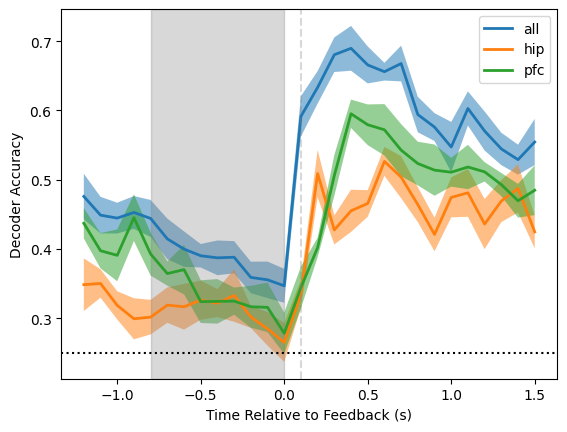

In [8]:
fig, ax = plt.subplots()
for region in REGIONS: 
    accs = np.load(os.path.join(OUTPUT_DIR, f"rpe_groups_{region}_no_proj_all_test_accs.npy"))

    # plots the mean and standard deviation of decoding accuracy across splits, by time. 
    visualization_utils.visualize_accuracy_across_time_bins(
        accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"{region}",
        right_align=True, 
    )
ax.legend()
# add grey band for selection period
ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
# add dotted line for feedback start
ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
# add estimated chance
ax.axhline(0.25, color='black', linestyle='dotted', label="Estimated Chance")
ax.set_xlabel("Time Relative to Feedback (s)")
ax.set_ylabel("Decoder Accuracy")

### High value Decoding

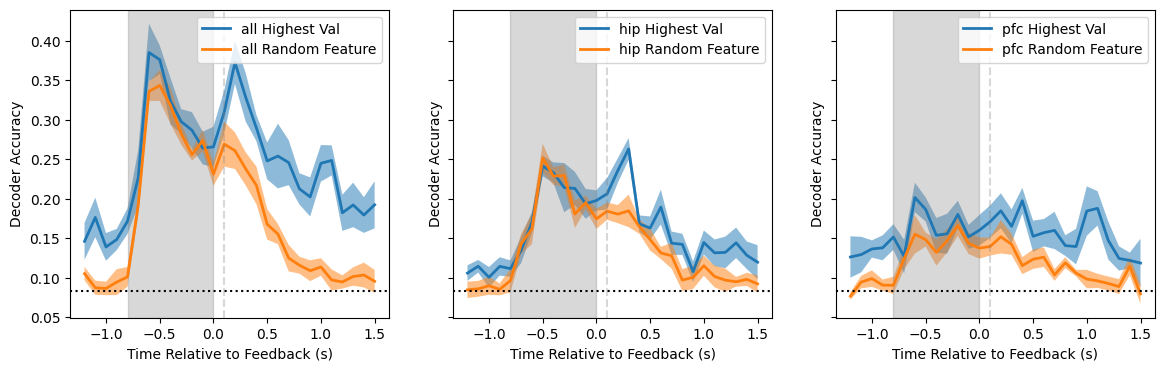

In [24]:
fig, axs = plt.subplots(1, 3, figsize=(14, 4), sharey=True)
for i, region in enumerate(REGIONS):
# for i, region in enumerate(["pfc", "hip"]):
    ax = axs[i]
    if region in ["pfc", "hip"]:
        high_val_accs = np.load(os.path.join(OUTPUT_DIR, f"high_val_MaxFeat_{region}_rpe_sess_test_accs.npy"))
        random_accs = np.load(os.path.join(OUTPUT_DIR, f"high_val_RandomMaxFeat_{region}_rpe_sess_test_accs.npy"))
    else:
        high_val_accs = np.load(os.path.join(OUTPUT_DIR, "high_val_MaxFeat_rpe_sess_test_accs.npy"))
        random_accs = np.load(os.path.join(OUTPUT_DIR, "high_val_RandomMaxFeat_rpe_sess_test_accs.npy"))
    visualization_utils.visualize_accuracy_across_time_bins(
        high_val_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"{region} Highest Val",
        right_align=True, 
    )
    visualization_utils.visualize_accuracy_across_time_bins(
        random_accs,
        PRE_INTERVAL / 1000, POST_INTERVAL / 1000, INTERVAL_SIZE / 1000,  # by default these are in seconds
        ax,
        label=f"{region} Random Feature",
        right_align=True, 
    )
    ax.legend()
    # add grey band for selection period
    ax.axvspan(-0.8, 0, alpha=0.3, color='gray')
    # add dotted line for feedback start
    ax.axvline(0.098, alpha=0.3, color='gray', linestyle='dashed')
    # add estimated chance
    ax.axhline(1/12, color='black', linestyle='dotted', label="Estimated Chance")
    ax.set_xlabel("Time Relative to Feedback (s)")
    ax.set_ylabel("Decoder Accuracy")